In [1]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates 

import numpy as np

import pandas as pd
import pickle

import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

In [2]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

lstm=pickle.load(open('/Users/luca/Desktop/ThesisKernelMethods/experiments/point/models/lstm_load.pkl', 'rb'))

In [3]:
df_train=pd.read_csv("/Users/luca/Desktop/GEFCom2014 Data/Load/L-train.csv")

y_train=df_train["LOAD"]
X_train=df_train[["DAY","MONTH","HOUR","DAY_OF_WEEK","IS_HOLIDAY","w_avg"]]

df_test=pd.read_csv(f"/Users/luca/Desktop/GEFCom2014 Data/Load/Task 1/L1-test_clean.csv")

X_test=df_test[["DAY",  "MONTH",  "HOUR",  "DAY_OF_WEEK",  "IS_HOLIDAY",  "w_avg"]]
y_test=df_test["LOAD"]

In [4]:
# window size for historical data, we consider the last 24 data, hourly frequency
window_size = 24

# create sequences of data for lstm
sequences = []
for i in range(window_size, len(df_train)):
    # get last 24 observations of data
    sequence = df_train.iloc[i - window_size:i]
    sequences.append(sequence)

# split sequences into input features and targets
X = []
y = []
for sequence in sequences:
    X.append(sequence[["DAY","MONTH","HOUR","DAY_OF_WEEK","IS_HOLIDAY","w_avg"]].values)
    y.append(sequence['LOAD'].values[-1])

X = np.array(X)
y = np.array(y)



In [5]:
# scale data for better performance
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).reshape(-1)

# train test split
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# numpy to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

X_scaled.shape, y_scaled.shape

((50352, 24, 6), (50352,))

In [6]:
df_test_prev=pd.read_csv("/Users/luca/Desktop/GEFCom2014 Data/Load/L-train.csv")
df_test=pd.read_csv("/Users/luca/Desktop/GEFCom2014 Data/Load/Task 1/L1-test_clean.csv")

# df_test_prev=pd.read_csv("/Users/luca/Desktop/GEFCom2014 Data/Load/Task 1/L1-test_clean.csv")
# df_test=pd.read_csv("/Users/luca/Desktop/GEFCom2014 Data/Load/Task 2/L2-test_clean.csv")

In [8]:
df_task=pd.concat([df_test_prev[-24:],df_test], ignore_index=True)[["DAY",  "MONTH",  "HOUR",  "DAY_OF_WEEK",  "IS_HOLIDAY",  "w_avg"]]

window_size = 24

sequences = []
for i in range(window_size, len(df_task)):
    sequence = df_task.iloc[i - window_size:i]
    sequences.append(sequence)

X_task = []
for sequence in sequences:
    X_task.append(sequence[["DAY","MONTH","HOUR","DAY_OF_WEEK","IS_HOLIDAY","w_avg"]].values)

X_task = np.array(X_task)

X_task_scaled = scaler_X.transform(X_task.reshape(-1, X_task.shape[-1])).reshape(X_task.shape)

X_task_tensor = torch.tensor(X_task_scaled, dtype=torch.float32)

lstm.eval()
with torch.no_grad():
    y_hat = lstm(X_task_tensor).squeeze().numpy()
    y_hat = scaler_y.inverse_transform(y_hat.reshape(-1, 1)).reshape(-1)


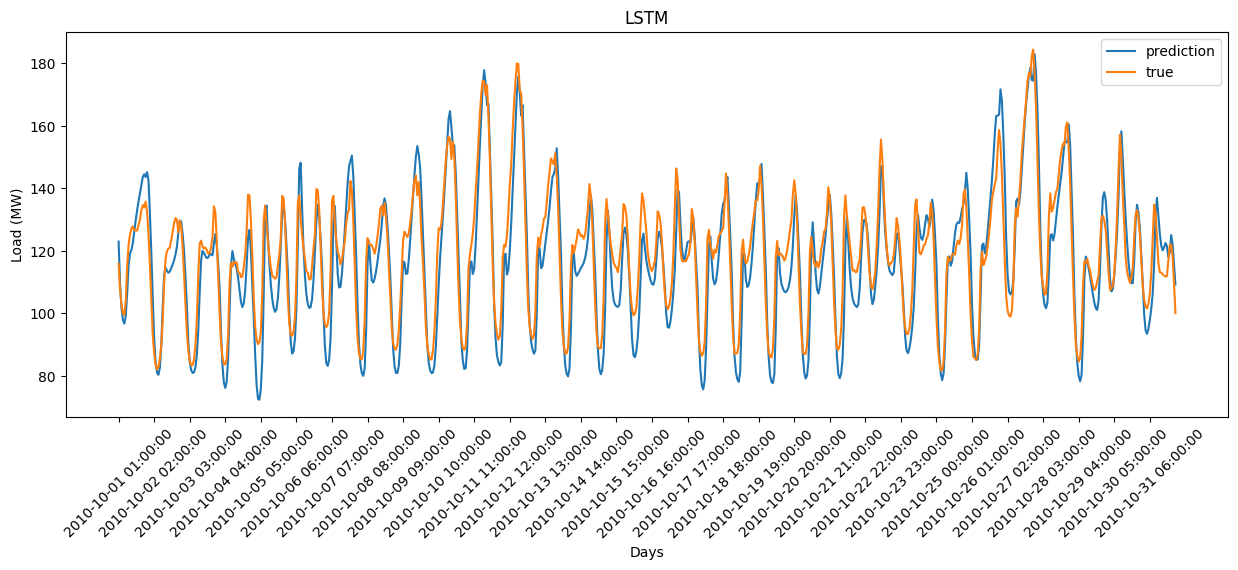

In [10]:
plt.figure(figsize=(15,5))

plt.plot(y_hat, label="prediction")
plt.plot(df_test["DS"],df_test["LOAD"], label="true")

plt.xticks(np.arange(0,len(df_test["LOAD"])+1,25), rotation=45)

plt.xlabel("Days")
plt.ylabel("Load (MW)")
plt.title("LSTM")
plt.legend()
# plt.savefig("/Users/luca/Desktop/ThesisKernelMethods/thesis/images/lstm_price.png")
plt.show()

In [14]:
np.sqrt(mean_squared_error(y_hat, df_test["LOAD"]))

9.178213837797186